author: ChiuMing (Eddie) Lam

# Time Series: AutoARIMA & Holt Winters EMS
<br>
In this project I will attempt to forecast Walmart sales with two classical time-series forecasting models:<br>
1. Seasonal AutoRegressive Integrated Moving Average<br>
2. Holt Winters Expotential Smoothing
<br>
<br>

**** Big thanks to Taylor G. Smith and the the contributors of the PMDARIMA library!!***

In [77]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 5]

## Walmart Sales Data

For this independent practice, we'll analyze Walmart's weekly sales data over a two-year period from 2010 to 2012.

The data set is again separated by store and department, but we'll focus on analyzing one store for simplicity.

The data include:

* `Store`: The store number.
* `Dept`: The department number.
* `Date`: The week.
* `Weekly_Sales`: Sales for the given department in the given store.
* `IsHoliday`: Whether the week is a special holiday week.

### 1) Preprocess the data using Pandas.

* **Load the data.**
* **Convert the `Date` column to a `datetime` object.**
* **Set `Date` as the index of the DataFrame.**

In [4]:
walmart = pd.read_csv('data/train.csv')

In [5]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
walmart.Date = pd.to_datetime(walmart.Date)

In [10]:
walmart.index = walmart.Date

In [13]:
walmart.drop('Date', axis=1, inplace=True)

In [14]:
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


### 2) Filter the DataFrame to Store 1 sales and aggregate over departments to compute the total weekly sales per store. Store this in a new DataFrame.

In [22]:
store1 = walmart.loc[walmart.Store==1,:]

In [90]:
#resample and rolling
store1= store1.groupby(store1.index).aggregate({'Weekly_Sales':'sum'})

### 3) Plot the rolling mean for `Weekly_Sales`. What general trends do you observe?

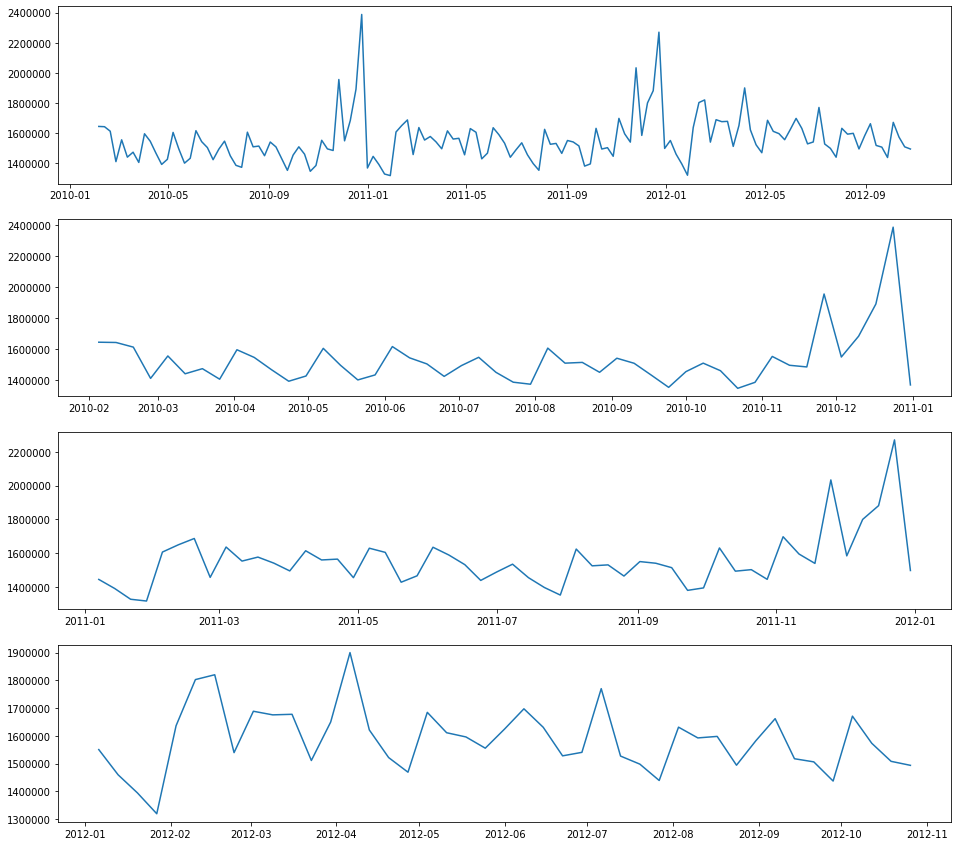

In [109]:
# subplot(nrows, ncols, pos)
plt.figure(figsize=[16,15])
plt.subplot(411)
plt.plot(store1)
plt.subplot(412)
plt.plot(store1['2010'])
plt.subplot(413)
plt.plot(store1['2011'])
plt.subplot(414)
plt.plot(store1['2012'])

There some seasonal pattern overall, and the pattern spike when it approaches new year

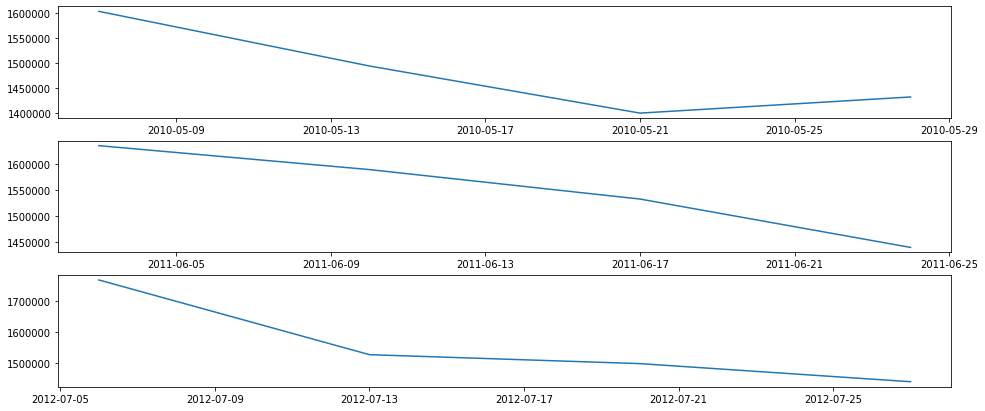

In [106]:
# subplot(nrows, ncols, pos)
plt.figure(figsize=[16,7])
plt.subplot(311)
plt.plot(store1['2010-05'])
plt.subplot(312)
plt.plot(store1['2011-06'])
plt.subplot(313)
plt.plot(store1['2012-07'])

Sales tend to be the highest at the start of month then gradually decreases 'til the end of that month, then rises again when entering into a new month

### 4) Compute the `1`, `13`, and `52` autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.

In [61]:
print('lag1:',store1.Weekly_Sales.autocorr())
print('lag13:',store1.Weekly_Sales.autocorr(lag=13))
print('lag52:',store1.Weekly_Sales.autocorr(lag=52))

lag1: 0.9685711543841525
lag13: 0.9105506301413794
lag52: 0.8119746276802184


(0, 53)

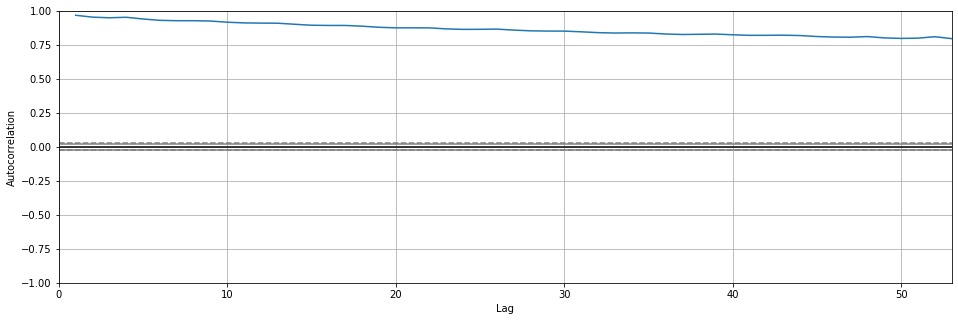

In [70]:
ax = pd.plotting.autocorrelation_plot(store1.Weekly_Sales)
ax.set_xlim([0,53])

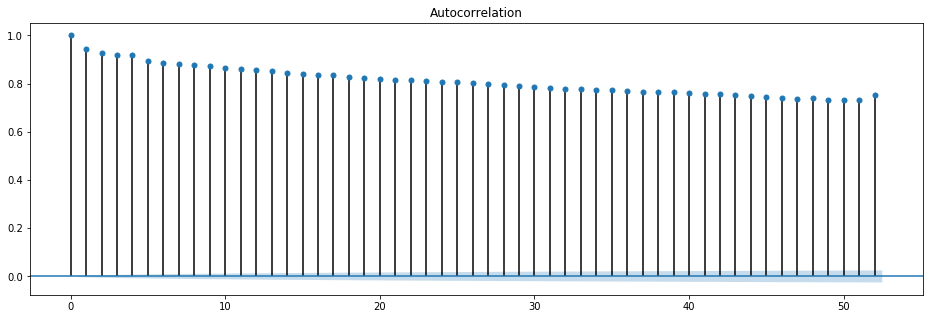

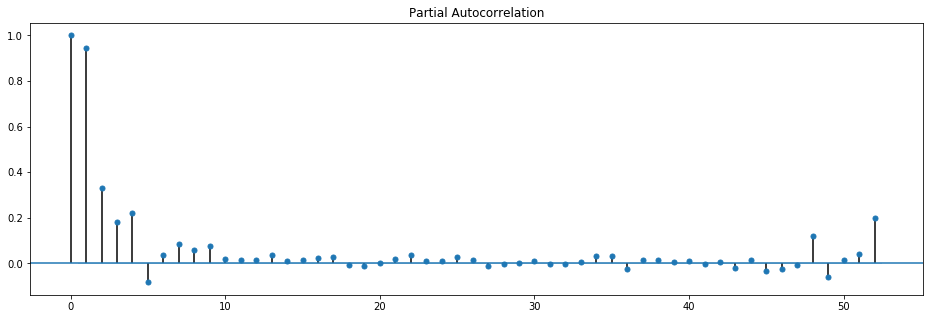

In [75]:
plot_acf(walmart.Weekly_Sales, lags=52);
plot_pacf(walmart.Weekly_Sales, lags=52);

AR: 1<br>
MA: 1

### 5) Create a decomposition plot for the Store 1 sales data. 

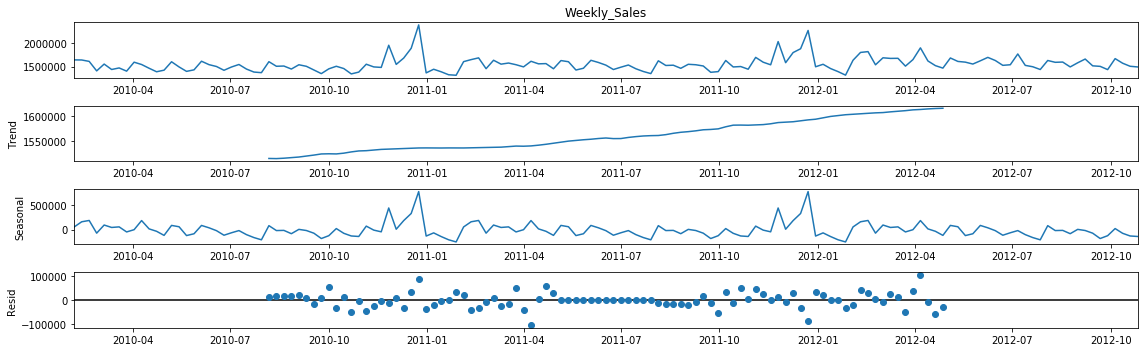

In [108]:
sm.tsa.seasonal_decompose(store1.Weekly_Sales).plot();

Above shows the Trend, Seasonality, and Irregularity element separately in the data.<br>
We can see that there's an upward trend in the data.<br>
We can also see there's some sort of seasonal pattern(monthly as investigated previously) and some cyclical pattern -- sales tend to peak around new year.

### 6) Based on the analyses above, what can we deduce about this time series?

Since there's the element of trend and seasonality, we will want to incorporate models that take those two into considerations.<br>
Therefore, in the following, I will use:<br>
1. Holt's Winters Expotential Smoothing
2. Seasonal AutoRegressive Integrated Moving Average

---
splitting the data into training and testing sets.
1. data from 2010 to 2011 will be used for training
2. data from after 2011 will be used for testing

In [115]:
train = store1.Weekly_Sales['2010':'2011']
test = store1.Weekly_Sales['2012']

Training Set No. Rows: 100
Testing Set No. Rows: 43


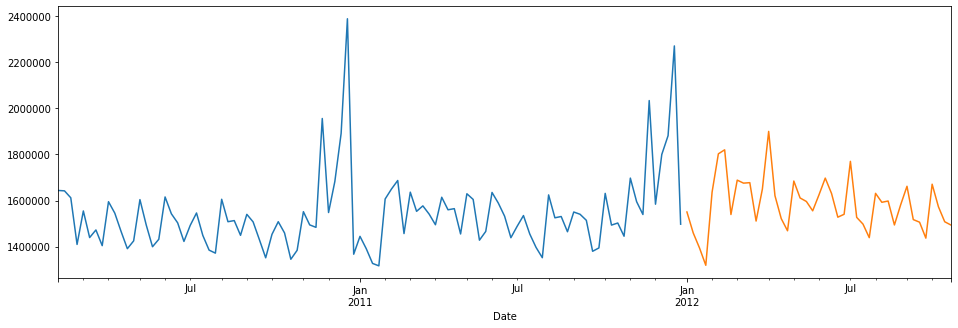

In [120]:
print('Training Set No. Rows:',train.shape[0])
print('Testing Set No. Rows:',test.shape[0])
train.plot(label='Training')
test.plot(label='Testing')

## AutoRegressive Integrated Moving Average

In [300]:
import pmdarima as pm
model = pm.auto_arima(train, seasonal=True, error_action='ignore', suppress_warnings=True, m=52, stepwise=True)

In [302]:
SARIMA_forecasts = model.predict(test.shape[0])
SARIMA_forecasts = pd.Series(SARIMA_forecasts)
SARIMA_forecasts.index = test.index
# forecasts

## Holt Winter's Expotential Smoothing

In [303]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

EMSW_model = ExponentialSmoothing(train, seasonal_periods=52, seasonal='add').fit(use_brute=True)
EMSW_forecast = EMSW_model.predict(start='2012-01-06 00:00:00', end='2012-10-26 00:00:00')

/home/eddie/snap/jupyter/common/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, '')

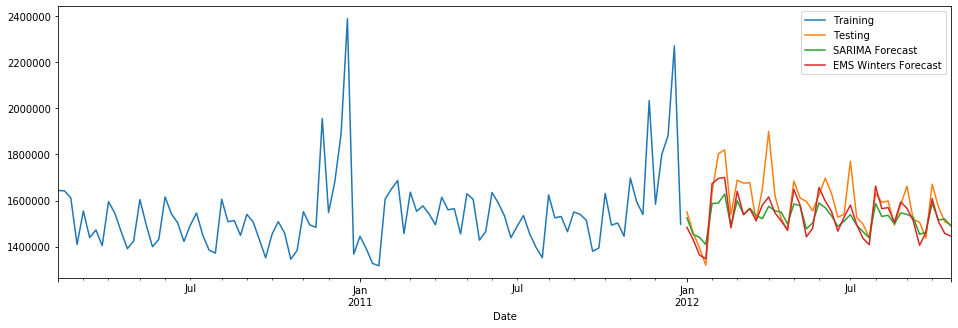

In [304]:
train.plot(label='Training')
test.plot(label='Testing')
SARIMA_forecasts.plot(label='SARIMA Forecast')
EMSW_forecast.plot(label='EMS Winters Forecast')
plt.legend()
plt.title('')

In [305]:
print("SARIMA MAE:", (test-SARIMA_forecasts).abs().mean())
print("Holt Winters EMS MAE:", (test-EMSW_forecast).abs().mean())

SARIMA MAE: 72438.55941670001
Holt Winters EMS MAE: 62130.13327875727


# Conclusion:
Holt Winters EMS is a better model at predicting. 